In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, plot_confusion_matrix, make_scorer, recall_score, accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer, make_column_transformer
from xgboost import XGBClassifier 
import xgboost as xgb

import scipy


%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)


In [ ]:
y = pd.read_csv('../../src/data/y_dataframe.csv', index_col= 0, squeeze= True)
X = pd.read_csv('../../src/data/X_dataframe.csv', index_col= 0)

In [3]:
# From previous notebook it was discovered the total minutes was directly correlated to the charge so we dropped all the minute columns. 
# Also state didnt seem to play a huge impportance so we took it out to reduce calculation time. 

In [4]:
X.drop(columns=['total day minutes', 'total eve minutes', 'total night minutes', 'total intl minutes', 'state'], axis=1, inplace= True)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size = .2)
X_t, X_val, y_t, y_val = train_test_split(X_train,y_train, random_state=42, test_size = .2)

In [6]:
numerical_features = X_t.select_dtypes(exclude='object').columns
categorical_features = X_t.select_dtypes(include='object').columns

In [7]:
def model_output(model, X_t, X_val, y_t, y_val):
    '''Can be used on final test and train validation''
    input:   model, X_t, X_val, y_t, y_val
    or 
    input:   model, X_train, X_test, y_train, y_test
    '''
    
    model.fit(X_t, y_t)
    y_hat = model.predict(X_val)
    
    print(f'''The Cross Val accuracy is: {cross_val_score(estimator = model, X = X_t,y = y_t, cv = 3, scoring = 'accuracy').mean()}''')
    print(f'The test Accuracy is: {accuracy_score(y_val, y_hat)}')
    print(confusion_matrix(y_val, y_hat))
    print(classification_report(y_val, y_hat))

        
    return

# Pipeline

In [8]:
preprocess = make_column_transformer(
    (OneHotEncoder(sparse = False, drop ='first'), categorical_features), remainder = 'passthrough')

In [9]:
pipe_forest = Pipeline([
    ('pp', preprocess),
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state= 42)),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 5, max_features = .5, min_samples_split = 3, n_estimators = 300 ))])


# Random forest model

Baseline model

In [ ]:
{'rf__max_depth': 5,
 'rf__max_features': 0.5,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 300}

In [67]:
y_test.value_counts()

False    566
True     101
Name: churn, dtype: int64

In [206]:
y_hat = model_output(pipe_forest, X_train, X_test, y_train, y_test)

The Cross Val accuracy is: 0.9126055189047314
The test Accuracy is: 0.9295352323838081
[[535  31]
 [ 16  85]]
              precision    recall  f1-score   support

       False       0.97      0.95      0.96       566
        True       0.73      0.84      0.78       101

    accuracy                           0.93       667
   macro avg       0.85      0.89      0.87       667
weighted avg       0.93      0.93      0.93       667



In [65]:
model_output(pipe_forest, X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.899170645061178
The test Accuracy is: 0.9157303370786517
[[422  34]
 [ 11  67]]
              precision    recall  f1-score   support

       False       0.97      0.93      0.95       456
        True       0.66      0.86      0.75        78

    accuracy                           0.92       534
   macro avg       0.82      0.89      0.85       534
weighted avg       0.93      0.92      0.92       534



# Random forest with grid models

In [346]:
grid_forest = {
    'rf__min_samples_split': [2, 3, 5], 
    'rf__n_estimators' : [100, 300],
    'rf__max_depth': [5, 15, 25, None],
    'rf__max_features': ['sqrt', 'log2', 10, .5]
}

In [45]:
scorers_forest = {
    'recall_score': make_scorer(recall_score),
    'precision_score': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
    }

# Maximizing f1

In [204]:
grid_search_f1 = GridSearchCV(pipe_forest, grid_forest, scoring=scorers_forest, refit='f1',
                           cv=3, return_train_score=True, n_jobs=-1)

model_output(grid_search_f1, X_t, X_val, y_t, y_val)

NameError: name 'grid_forest' is not defined

In [352]:
grid_search_f1.best_params_

{'rf__max_depth': 25,
 'rf__max_features': 0.5,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 100}

In [353]:
grid_search_recall = GridSearchCV(pipe_forest, grid_forest, scoring=scorers_forest, refit='recall_score',
                           cv=3, return_train_score=True, n_jobs=-1)

model_output(grid_search_recall, X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.9015167422726703
The test Accuracy is: 0.9157303370786517
[[422  34]
 [ 11  67]]
              precision    recall  f1-score   support

       False       0.97      0.93      0.95       456
        True       0.66      0.86      0.75        78

    accuracy                           0.92       534
   macro avg       0.82      0.89      0.85       534
weighted avg       0.93      0.92      0.92       534



In [94]:
grid_search_recall.best_params_

NameError: name 'grid_search_recall' is not defined

In [142]:
grid_search_precision = GridSearchCV(pipe_forest, grid_forest, scoring=scorers_forest, refit='precision_score',
                           cv=3, return_train_score=True, n_jobs=-1)

model_output(grid_search_precision, X_t, X_val, y_t, y_val)

NameError: name 'grid_forest' is not defined

In [357]:
grid_search_precision.best_params_

{'rf__max_depth': 25,
 'rf__max_features': 0.5,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 100}

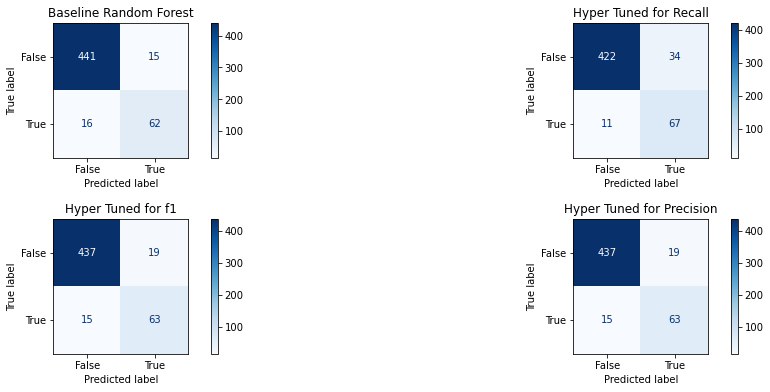

In [358]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
fig.tight_layout(pad=4.0)

axes[0,0].set_title("Baseline Random Forest")
axes[1,0].set_title("Hyper Tuned for f1")
axes[0,1].set_title("Hyper Tuned for Recall")
axes[1,1].set_title("Hyper Tuned for Precision")

plot_confusion_matrix(pipe_forest, X_val, y_val, ax=axes[0,0], cmap="Blues")
plot_confusion_matrix(grid_search_f1, X_val, y_val, ax=axes[1,0], cmap="Blues")
plot_confusion_matrix(grid_search_recall, X_val, y_val, ax=axes[0,1], cmap="Blues")
plot_confusion_matrix(grid_search_precision, X_val, y_val, ax=axes[1,1], cmap="Blues")

Hyper Tuned for Precision seems to give the best overall results. Ideally we want our False negative as low as possible like the one hypertuned for recall.

In [ ]:
# comparing models

In [ ]:
fig, ax = plt.subplots(figsize =(14,10))
sns.lineplot(x = [0,1,2,3], y = [.94,.80,.78,.79])

sns.lineplot(x = [0,1,2,3], y = [.94,.77,.81,.79] )

sns.lineplot(x = [0,1,2,3], y = [.91,.66,.86,.76])


plt.title('Different HyperTuned Models', fontsize = 20)
plt.xlabel('')
plt.ylabel('Score', fontsize = 20)

ax.tick_params(labelsize = 20)
ax.se
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1'])
plt.tight_layout()
plt.legend()

# XGBoost classifier

In [ ]:
# random_state = 42, learning_rate = 0.01, max_depth = 4, n_estimators = 500  Best performance towards recall
# random_state = 42, learning_rate = 0.05, max_depth = 20, n_estimators = 300   Best overall performance 
# random_state = 42, learning_rate = 0.01, max_depth = 4, n_estimators = 500, gamma = 0.3   towards recall

In [10]:
pipe_xg = Pipeline([
    ('pp', preprocess),
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state= 42)),
    ('xg', XGBClassifier(random_state = 42, learning_rate = 0.01, max_depth = 4, n_estimators = 500, gamma = 0.3))])


In [11]:
model_output(pipe_xg, X_train, X_test, y_train, y_test)

The Cross Val accuracy is: 0.9347378874937929
The test Accuracy is: 0.9490254872563718
[[548  18]
 [ 16  85]]
              precision    recall  f1-score   support

       False       0.97      0.97      0.97       566
        True       0.83      0.84      0.83       101

    accuracy                           0.95       667
   macro avg       0.90      0.90      0.90       667
weighted avg       0.95      0.95      0.95       667



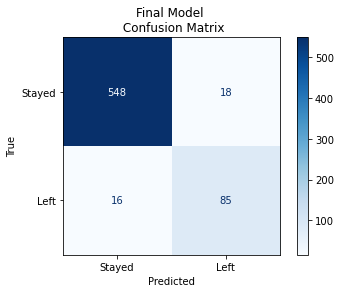

In [18]:
fig, ax = plt.subplots()

ax.set_title('Final Model \n Confusion Matrix')
plot_confusion_matrix(pipe_xg, X_test, y_test, ax=ax, cmap = 'Blues', display_labels=['Stayed','Left']);
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('../report/figures/Final_model', dpi = 300)


In [202]:
model_output(pipe_xg, X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.9273020212225062
The test Accuracy is: 0.9288389513108615
[[433  23]
 [ 15  63]]
              precision    recall  f1-score   support

       False       0.97      0.95      0.96       456
        True       0.73      0.81      0.77        78

    accuracy                           0.93       534
   macro avg       0.85      0.88      0.86       534
weighted avg       0.93      0.93      0.93       534



In [20]:
from operator import itemgetter

In [21]:
a = preprocess.get_feature_names()

In [22]:
b = pipe_xg.steps[3][1].feature_importances_

In [23]:
b.sum()

0.9999999

In [24]:
c = list(zip(a,b))

In [25]:
c = sorted(c,key=itemgetter(1), reverse = True)

In [26]:
c[0:5]

[('onehotencoder__x0_yes', 0.20962155),
 ('customer service calls', 0.18564038),
 ('total intl calls', 0.13097413),
 ('total day charge', 0.12775207),
 ('onehotencoder__x1_yes', 0.08358827)]

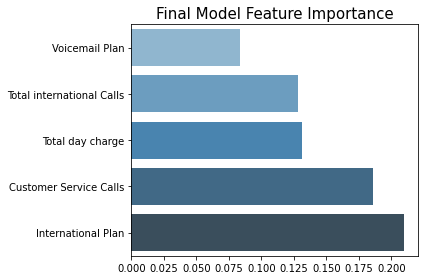

In [33]:

list_of_names = ['International Plan', 'Customer Service Calls', 'Total day charge', 'Total international Calls', 'Voicemail Plan']

forest4_hunter2_ylabel = [i[0] for i in c][:5]
forest4_hunter2_xlabel = [i[1] for i in c][:5]
fig, ax = plt.subplots()
sns.barplot(forest4_hunter2_xlabel,forest4_hunter2_ylabel,orient = 'h', palette="Blues_d").set_yticklabels(list_of_names)
ax.invert_yaxis()
plt.title('Final Model Feature Importance', fontsize = 15)
plt.tight_layout()
plt.savefig('../report/figures/Final_model_features', dpi = 300)

In [143]:
pipe_xg.steps[0]

('pp',
 ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder',
                                  OneHotEncoder(drop='first', sparse=False),
                                  Index(['international plan', 'voice mail plan'], dtype='object'))]))

In [102]:
model_output(pipe_xg, X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.9254267282079726
The test Accuracy is: 0.9288389513108615
[[433  23]
 [ 15  63]]
              precision    recall  f1-score   support

       False       0.97      0.95      0.96       456
        True       0.73      0.81      0.77        78

    accuracy                           0.93       534
   macro avg       0.85      0.88      0.86       534
weighted avg       0.93      0.93      0.93       534



# XG Grid to optimize recall

In [110]:
xg_param = {
    'xg__max_depth': [4,6,10,20],
    'xg__learning_rate': [0.1, 0.01, 0.05],
    'xg__n_estimators': [300, 500],
    'xg__gamma': [0,.05,.1,.5],
}


TypeError: 'float' object cannot be interpreted as an integer

In [121]:
list(np.arange(5.5, 15.5, 2.5))

[5.5, 8.0, 10.5, 13.0]

In [122]:
xg_param = {'xg__gamma': list(np.arange(0, .5, .05))}

In [123]:
grid_search_xg = GridSearchCV(pipe_xg, param_grid= xg_param, scoring ='recall', cv=3, n_jobs=-1)

In [125]:
model_output(grid_search_xg , X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.9254267282079726
The test Accuracy is: 0.9288389513108615
[[433  23]
 [ 15  63]]
              precision    recall  f1-score   support

       False       0.97      0.95      0.96       456
        True       0.73      0.81      0.77        78

    accuracy                           0.93       534
   macro avg       0.85      0.88      0.86       534
weighted avg       0.93      0.93      0.93       534



lowest we were getting for recall was .85, but everything else suffers a lot and you get a lot more false positives. 

# XG grid to optimize f1

In [ ]:
gam

In [32]:
xg_f1 = GridSearchCV(pipe_xg, param_grid= xg_param, scoring ='f1', cv=3, n_jobs=-1)

In [33]:
model_output(xg_f1 , X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.9427817726801503
The test Accuracy is: 0.949438202247191
[[444  12]
 [ 15  63]]
              precision    recall  f1-score   support

       False       0.97      0.97      0.97       456
        True       0.84      0.81      0.82        78

    accuracy                           0.95       534
   macro avg       0.90      0.89      0.90       534
weighted avg       0.95      0.95      0.95       534



In [35]:
xg_f1.best_params_

{'xg__gamma': 0.1,
 'xg__learning_rate': 0.05,
 'xg__max_depth': 20,
 'xg__n_estimators': 300}